# Dubins Car

The Dubins car problem is non-holonomic, and while each configuration is possible, the manner in which those configurations can be reached is reduced. Notably we have $$\dot y \cos \theta - \dot x \sin \theta = 0$$

Hence, unlike for the other examples we cannot rely on the linearized LQR controller to act as performance / nominal controller. Instead we solve the reachability problem for reaching a target (without accounting for the obstacle avoidance) and use the found policy as the performance policy.

For hybrid example, the car is expected to reach a point and then another point, while avoiding two obstacles.
There are two different dynamics on the road, with different control limits.

In [37]:
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import dubins_nominal_hjr_control as nominal_hjr_control
import matplotlib
import matplotlib.animation as anim
import os

In [9]:
sys.path.insert(1, '../lib')
import refine_cbfs
import experiment_wrapper
import cbf_opt
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF

In [10]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '80',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})

params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [15]:
# original system cannot control velocity, we introduce acceleration in the new system.

use_new_system =  True # choose new system or not

dubins_vel = 1.0  # m / s 
if new_system:
    umin_dry = np.array([-0.5, -2.])  # rad / s and m^2 / s
    umax_dry = np.array([0.5, 2.]) 
    umin_wet = np.array([-0.2, -0.5])
    umax_wet = np.array([0.2, 0.5])
    file_name = '_new'
else:
    umin_dry = np.array([-0.5])  # rad / s
    umax_dry = np.array([0.5])
    file_name = ''
dt = 0.05 # s

Constraint set of the problem. Two rectangular constraints in the $(x,y)$ space

In [12]:
obstacle_center = np.array([[5.0, 5.0], [10.0, 5.0]])
obstacle_length = np.array([2.0, 2.0])

### Dynamics

Dynamics of the Dubins car problem (control affine) in the format of `cbf_opt`

`DubinsJNPDynamics` is required for usage with `hj_reachability` module

In [13]:
# old system with fixed velocity, not used

class DubinsDynamics(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1
        params["periodic_dims"] = [2]
        self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = self.v * np.cos(state[..., 2])
        f[..., 1] = self.v * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = -self.v * np.sin(state[..., 2])
        J[..., 1, 2] = self.v * np.cos(state[..., 2])
        return J
        
class DubinsJNPDynamics(DubinsDynamics):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -self.v * jnp.sin(state[2])],
            [0, 0, self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [14]:
# we are using this new system

class DubinsDynamicsNew(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA', 'VELOCITY']
    CONTROLS = ['OMEGA', 'ACCELERATION']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2
        params["periodic_dims"] = [2]
        # self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = np.cos(state[..., 3]) * np.cos(state[..., 2])
        f[..., 1] = np.cos(state[..., 3]) * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        B[..., 3, 1] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = - np.cos(state[..., 3]) * np.sin(state[..., 2])
        J[..., 1, 2] = np.cos(state[..., 3]) * np.cos(state[..., 2])
        J[..., 0, 3] = - np.sin(state[..., 3]) * np.cos(state[..., 2])
        J[..., 1, 3] = - np.sin(state[..., 3]) * np.sin(state[..., 2])
        return J
        
class DubinsJNPDynamicsNew(DubinsDynamicsNew):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([jnp.cos(state[3]) * jnp.cos(state[2]), jnp.cos(state[3]) * jnp.sin(state[2]), 0, 0])

    def control_matrix(self, state, time=0.0):
        return jnp.array([[0, 0], [0, 0], [1, 0], [0, 1]])

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(4), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -jnp.cos(state[3]) * jnp.sin(state[2]), - jnp.sin(state[3]) * jnp.cos(state[2])],
            [0, 0, jnp.cos(state[3]) * jnp.cos(state[2]), - jnp.sin(state[3]) * jnp.sin(state[2])], 
            [0, 0, 0, 0],
            [0, 0, 0, 0]])

In [16]:
if use_new_system:
    dyn = DubinsDynamicsNew({"v": dubins_vel, "dt": dt}, test=True)
    dyn_jnp = DubinsJNPDynamicsNew({"v": dubins_vel, "dt": dt}, test=True)
else:
    dyn = DubinsDynamics({"v": dubins_vel, "dt": dt}, test=True)
    dyn_jnp = DubinsJNPDynamics({"v": dubins_vel, "dt": dt}, test=True)

### Constructing initial local CBFs

In [17]:
class DubinsCBF(ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        vf_value = (state[..., 0] - self.center[0]) ** 2 + (state[..., 1] - self.center[1]) ** 2 - self.r ** 2
        return vf_value

    def _grad_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 0] = 2 * (state[..., 0] - self.center[0])
        dvf_dx[..., 1] = 2 * (state[..., 1] - self.center[1])
        return dvf_dx

In [21]:
# dry CBF and wet CBF

dubins_cbf_dry = DubinsCBF(dyn, {"center": obstacle_center[0, :], "r": np.sqrt(np.max(obstacle_length))}, test=True)
dubins_cbf_wet = DubinsCBF(dyn, {"center": obstacle_center[1, :], "r": np.sqrt(np.max(obstacle_length))}, test=True)

### Environment
Defining the discretized state space and the location of obstacles

In [22]:
dyn_hjr_dry = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))
dyn_hjr_wet = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin_wet), jnp.array(umax_wet)))

low_bound = -5.
upp_bound = 20.
resolution_bound = int(201 / 4)

if use_new_system:
    state_domain = hj.sets.Box(lo=jnp.array([low_bound, low_bound, -jnp.pi, -5.]), hi=jnp.array([upp_bound, upp_bound, jnp.pi, 5.]))
    grid_resolution = (resolution_bound, resolution_bound, 41, 20)
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)
else:
    state_domain = hj.sets.Box(lo=jnp.array([low_bound, low_bound, -jnp.pi]), hi=jnp.array([upp_bound, upp_bound, jnp.pi]))
    grid_resolution = (resolution_bound, resolution_bound, 81)
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)    

In [35]:
def constraint_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    length = obstacle_length
    bottom_left = jnp.array(obstacle_center[0, :] - obstacle_length / 2)
    value_dry_obstacle = - jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], 
                               state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))
    bottom_right = jnp.array(obstacle_center[1, :] - obstacle_length / 2)
    value_wet_obstacle = - jnp.min(jnp.array([state[0] - bottom_right[0], bottom_right[0] + length[0] - state[0], 
                               state[1] - bottom_right[1], bottom_right[1] + length[1] - state[1]]))
    
    return value_dry_obstacle, value_wet_obstacle

obstacle_dry, obstacle_wet = hj.utils.multivmap(constraint_set, jnp.arange(grid.ndim))(grid.states)  # constraint l(x)
obstacle_all = jnp.minimum(obstacle_dry, obstacle_wet)
assert obstacle_dry.shape == obstacle_wet.shape, "Double check the obstacles computation"

## Start to find valid local CBFs using Dynamic Programming

In [44]:
# time setup
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)

# data saving path
dataset_path = "../dataset/dubins_data"
if not os.path.isdir(dataset_path):
    os.makedirs(dataset_path)

In [43]:
# computing local dry CBF values, takes around 3 mins on desktop

# initialization
dubins_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf_dry.tabularize_cbf(dubins_cbf_dry)

# backward reach setting
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings_dry = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle_dry))

# solving
init_value_dry = dubins_tabular_cbf_dry.vf_table 
target_values_hjr_dry = hj.solve(solver_settings_dry, dyn_hjr_dry, grid, times, obstacle_dry)
target_values_dry = hj.solve(solver_settings_dry, dyn_hjr_dry, grid, times, init_value_dry)

# saving
np.save(dataset_path + "/target_values_hjr_dry"+file_name+".npy", target_values_hjr_dry)
np.save(dataset_path + "/target_values_dry"+file_name+".npy", target_values_dry)

100%|##########| 10.0000/10.0 [01:39<00:00,  9.99s/sim_s]
100%|##########| 10.0000/10.0 [01:38<00:00,  9.90s/sim_s]


In [45]:
# computing local wet CBF values, takes around 2 mins on desktop

dubins_tabular_cbf_wet = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf_wet.tabularize_cbf(dubins_cbf_wet)

solver_settings_wet = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle_wet))
init_value_wet = dubins_tabular_cbf_wet.vf_table 

target_values_hjr_wet = hj.solve(solver_settings_wet, dyn_hjr_wet, grid, times, obstacle_wet)
target_values_wet = hj.solve(solver_settings_wet, dyn_hjr_wet, grid, times, init_value_wet)

np.save(dataset_path + "/target_values_hjr_wet"+file_name+".npy", target_values_hjr_wet)
np.save(dataset_path + "/target_values_wet"+file_name+".npy", target_values_wet)

100%|##########| 10.0000/10.0 [00:51<00:00,  5.10s/sim_s]
100%|##########| 10.0000/10.0 [00:49<00:00,  4.94s/sim_s]


In [46]:
# if you have computed values before, then just read them

target_values_wet = jnp.load(dataset_path + "/target_values_wet"+file_name+".npy")
target_values_hjr_wet = jnp.load(dataset_path + "/target_values_hjr_wet"+file_name+".npy")
target_values_dry = jnp.load(dataset_path + "/target_values_dry"+file_name+".npy")
target_values_hjr_dry = jnp.load(dataset_path + "/target_values_hjr_dry"+file_name+".npy")

In [47]:
# Now write computed CBF values in the 'refine_cbfs' format

tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_dry.vf_table = np.array(target_values_dry[-1])

tabular_cbf_wet = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_wet.vf_table = np.array(target_values_wet[-1])

In [50]:
# define switching conditions

switch_position = 8.0
switch_radius = .2
switch = abs(grid.states[..., 0] - switch_position) - switch_radius

# the intersection of safe dry and unsafe ice regions
unsafe_wet_values = target_values_dry * target_values_wet
safe_switch = jnp.maximum(switch, unsafe_wet_values[-1])
new_obstacle = jnp.minimum(safe_switch, target_values_dry[-1])

assert switch.shape == safe_switch.shape and switch.shape == new_obstacle.shape, "Double check the shapes of switching area and new obstacles"

# Start to refine the initial local dry CBF to be aware of safe switching

In [51]:
# initialization using initial dry CBF

refined_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)

refined_cbf.vf_table = np.array(target_values_dry[-1])
refined_cbf_jnp.vf_table = target_values_dry[-1]

In [52]:
# solving, takes around 2 mins on desktop

solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(new_obstacle))
init_value_refine = refined_cbf.vf_table 
target_values_refined_dry = hj.solve(solver_settings, dyn_hjr_dry, grid, times, init_value_refine)

np.save(dataset_path + "/target_values_refined_dry"+file_name+".npy", target_values_refined_dry)

100%|##########| 10.0000/10.0 [01:40<00:00, 10.06s/sim_s]


In [53]:
# if you have computed values before, then just read them

target_values_refined_dry = jnp.load(dataset_path + "/target_values_refined_dry"+file_name+".npy")

refined_cbf_hybrid = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
refined_cbf_hybrid.vf_table = np.array(target_values_refined_dry[-1])

## Running the experiment

In [55]:
if use_new_system:
    x0 = np.array([2, 5, np.pi / 3, 0.]) # initial state
else:
    x0 = np.array([2, 4, np.pi / 3])
    
n_sims_per_start = 1
t_sim = 10 * 2.0
target_height = 4.
mid_target_position = 10.5

We use HJ reachability to setup the nominal controller

In [31]:
target2 = np.array([mid_target_position , target_height, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target2, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
np.save("../../../dataset/dubins/performance_policy_vfs_2"+file_name+".npy", opt_ctrl.tv_vf)
    
nom_policy_tar2 = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|##########| 30.0000/30.0 [00:50<00:00,  1.68s/sim_s]


In [32]:
target3 = np.array([12, target_height, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target3, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
np.save("../../../dataset/dubins/performance_policy_vfs_3"+file_name+".npy", opt_ctrl.tv_vf)
    
nom_policy_tar3 = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|##########| 30.0000/30.0 [00:48<00:00,  1.63s/sim_s]


In [33]:
target1 = np.array([6, 7, 0])
target2 = np.array([mid_target_position , target_height, 0])
target3 = np.array([12, target_height, 0])


with open("../../../dataset/dubins/performance_policy_vfs_2"+file_name+".npy", "rb") as f:
    opt_ctrl2 = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target2, padding=jnp.array([.2, .2, jnp.pi / 6]))
    opt_ctrl2.tv_vf = jnp.load(f)


with open("../../../dataset/dubins/performance_policy_vfs_3"+file_name+".npy", "rb") as f:
    opt_ctrl3 = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target3, padding=jnp.array([.2, .2, jnp.pi / 6]))
    opt_ctrl3.tv_vf = jnp.load(f)

nom_policy_tar2 = nominal_hjr_control.NominalPolicy(opt_ctrl2)
nom_policy_tar3 = nominal_hjr_control.NominalPolicy(opt_ctrl3)   

### Setting up the safety filter

In [68]:
alpha = lambda x: 1. * x
# dubins_asif_tar1 = ControlAffineASIF(dyn, dubins_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar1)
# dubins_asif_ws_tar1 = ControlAffineASIF(dyn, tabular_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar1, umin=umin_dry, umax=umax_dry)

dubins_asif_tar2 = ControlAffineASIF(dyn, dubins_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar2)
dubins_asif_ws_tar2 = ControlAffineASIF(dyn, tabular_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar2, umin=umin_dry, umax=umax_dry)

dubins_asif_tar2_5 = ControlAffineASIF(dyn, dubins_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar3)
dubins_asif_ws_tar2_5 = ControlAffineASIF(dyn, tabular_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar3, umin=umin_dry, umax=umax_dry)

dubins_asif_tar3 = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3)
dubins_asif_ws_tar3 = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3, umin=umin_wet, umax=umax_wet)

dubins_asif_global_dry = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3)
dubins_asif_ws_global_dry = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3, umin=umin_dry, umax=umax_dry)

dubins_asif_global_wet = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3)
dubins_asif_ws_global_wet = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar3, umin=umin_wet, umax=umax_wet)

dubins_asif_ws_refined = ControlAffineASIF(dyn, refined_cbf_hybrid, alpha=alpha, nominal_policy=nom_policy_tar3, umin=umin_dry, umax=umax_dry)


### Rollout different CBFs / nominal controller

In [55]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [56]:
hybrid_mode = True

In [ ]:
import logging
import pandas as pd

logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
if hybrid_mode == False:
    results_df_single = experiment.run(dyn, {'Nominal': nom_policy_tar3, 'Analytical': dubins_asif_tar3, 'Refined': dubins_asif_ws_tar3})
    results_df = results_df_single.copy()
else:
    results_df_hybrid, jump_state, traj_all = experiment.run_hybrid(dyn, {'Nominal': nom_policy_tar2, 'Baseline': dubins_asif_ws_tar2_5, 'Refined': dubins_asif_ws_refined, 'Global': dubins_asif_ws_global_dry}, {'Nominal': nom_policy_tar3, 'Baseline': dubins_asif_ws_tar3, 'Refined': dubins_asif_ws_tar3, 'Global': dubins_asif_ws_global_wet}, switch_position)
    results_df = results_df_hybrid.copy()

### Visualizing the results

In [58]:
ts_experiment = TimeSeriesExperiment('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

Next, we remove the part of the trajectory that is beyond the target! (Dubins car can't stabilize so we consider a finite-time reaching scenario)

In [59]:
print(type(results_df))

<class 'pandas.core.frame.DataFrame'>


In [60]:
print(traj_all.shape)

(401, 4)


In [61]:
updated_df = results_df.copy()
for ctrl in updated_df.controller.unique():
    df = updated_df[(updated_df.controller == ctrl) & (updated_df.measurement == 'dist_to_goal')]
    min_val = df.value.min()
    t_min = df.t.loc[df.value == df.value.min()].values[0]
    condition = updated_df[(updated_df.controller == ctrl) & (updated_df.t > t_min)]
    updated_df = updated_df.drop(condition.index)
updated_df = updated_df.reset_index(drop=True)

## Visualizations for paper + demo + videos

### Figure in paper

In [62]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.2, 0.2, 0.2))
chosen_colors.append((0.7, 0.7, 0.7))

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [63]:
save_figure = True
offset = 0

In [64]:
surface_values = target_values_hjr_dry[-1][..., offset]
index_switch = int((switch_position - low_bound) / (upp_bound - low_bound) * resolution_bound)
rest_index = resolution_bound - index_switch
surface_values = jnp.concatenate((- jnp.ones((resolution_bound, index_switch)), jnp.ones((resolution_bound, rest_index))), axis=1)
print(surface_values.shape)
print(obstacle_all[..., offset, offset].shape)
print(obstacle_all[20, 30, offset, offset], obstacle_all[20, 20, offset, offset])

(50, 50)
(50, 50)
4.306122 -0.79591846


In [65]:
print(grid.coordinate_vectors[0].shape)

(50,)


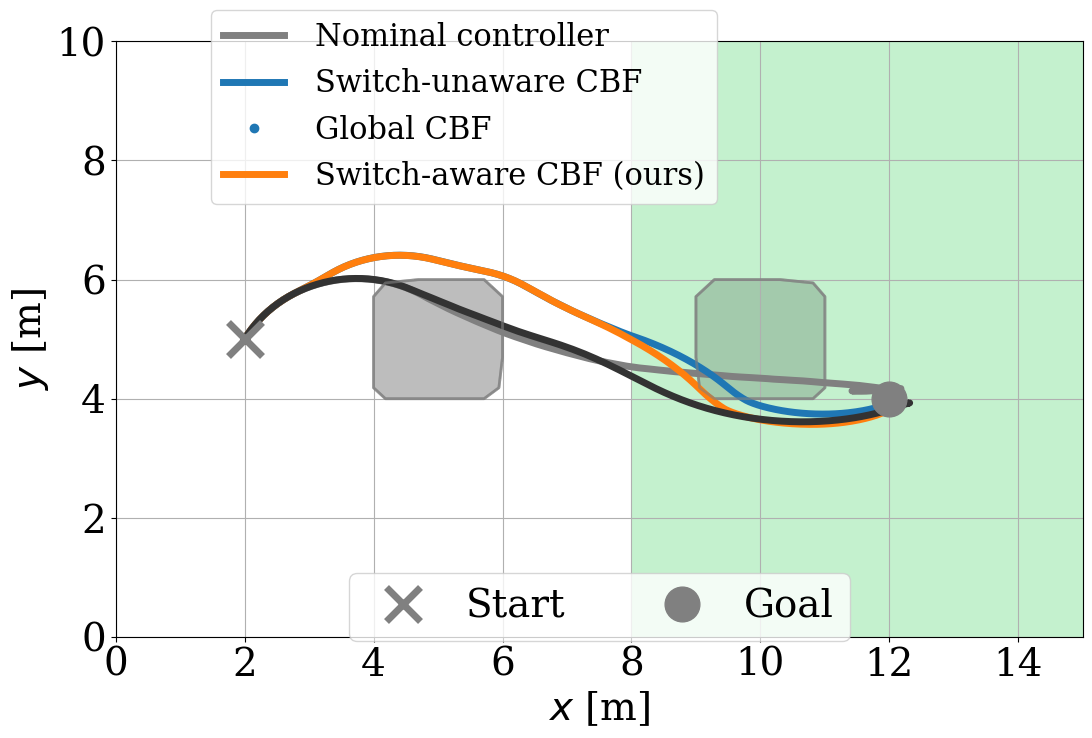

In [67]:
fig_comb, axs = plt.subplots(1, 1, figsize=(12, 8), sharey=True)
proxy = [] 
ax=axs

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., offset, offset].T, 
                 levels=[-10, 0], alpha=0.3, colors='grey')
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., offset, offset].T, 
           levels=[0], alpha=0.6, colors='grey', linewidths=2)
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], surface_values, 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)
# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
#                    target_values_0[0][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.6)
# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
#                    target_values_0[5][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.4)
# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
#                    target_values_0[10][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.2)
# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
#                    target_values_0[-1][..., offset], levels=[0], colors=np.array([colors[-1]]), linewidths=6)

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_ylabel('$y$ [m]')
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])
# ax.set_title(r"Iterations of CBF's safe set ($\theta=-\pi / 2$ slice)")
ax = axs
ss_experiment.plot(dyn, updated_df, ax=ax, color=chosen_colors, add_direction=False)
ax.grid(True)
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])
# ax.lines[3].set_linestyle((0, (5, 5, 1, 5)))
pal = sns.color_palette("colorblind")
sns.set_palette("colorblind")

l1 = ax.plot(x0[0], x0[1], 'x', markersize=25, mew=5, color='grey')
# l2 = ax.plot(opt_ctrl2.target[0], opt_ctrl2.target[1], 'o', markersize=25, color='grey', alpha=1)
l2 = ax.plot(opt_ctrl3.target[0], opt_ctrl3.target[1], 'o', markersize=25, color='grey', alpha=1)
miscs = [l1, l2]
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., 0, 0].T, levels=[-10, 0], 
            colors='grey', alpha=.3)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., 0, 0].T, levels=[0], 
           colors='grey', alpha=.6, linewidths=2)
ax.set_ylabel("$y$ [m]")
ax.set_xlabel("$x$ [m]")
# axs[1].set_title('Trajectories with safety filter')
# leg = axs[0].legend([misc[0] for misc in miscs], ['Start', 'Goals'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', 
#                     frameon=True, handletextpad=0.6)
# axs[0].add_artist(leg)

# axs[0].plot(x0[0], x0[1], 'x', markersize=25, mew=5, color='grey')
# # axs[0].plot(target2[0], target2[1], 'o', markersize=25, mew=5, color='grey')
# axs[0].plot(target3[0], target3[1], 'o', markersize=25, mew=5, color='grey')

leg = ax.legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', 
                    frameon=True, handletextpad=0.6)
ax.legend([ax.lines[0], ax.lines[3], ax.lines[4], ax.lines[6]], ["Nominal controller", "Switch-unaware CBF", "Global CBF", "Switch-aware CBF (ours)"], 
               fontsize="22", bbox_to_anchor=[.36, 0.89], ncol=1, columnspacing=0.5, handletextpad=1.0, loc='center', frameon=True)
ax.add_artist(leg)
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], surface_values, 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)

fig_comb.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

if save_figure:
    plt.savefig("dubins.png", dpi=400, bbox_inches='tight')


In [373]:
print(traj_all[100:180, ...])

[[ 4.80436062  6.40964129 -0.16090779 -0.05354151]
 [ 4.85364401  6.40164206 -0.16675729  0.0462603 ]
 [ 4.90289767  6.39335166 -0.17062158 -0.05354715]
 [ 4.95210102  6.38487408 -0.17278989  0.04620958]
 [ 5.00130388  6.37628669 -0.17395469 -0.05357039]
 [ 5.05047864  6.36764517 -0.17409123  0.04616346]
 [ 5.0996704   6.35899374 -0.17370505 -0.05360316]
 [ 5.14884722  6.35036451 -0.17264704  0.04612016]
 [ 5.19805152  6.34178411 -0.17133709 -0.05364135]
 [ 5.24724854  6.33327137 -0.16956642  0.04607893]
 [ 5.29647913  6.32484258 -0.16790157 -0.05368714]
 [ 5.34570498  6.31649893 -0.16608755  0.04604585]
 [ 5.39496467  6.30824144 -0.16441461 -0.05373287]
 [ 5.4442192   6.30006951 -0.16260417  0.04601557]
 [ 5.49350742  6.29198365 -0.16247955  0.14601557]
 [ 5.54232382  6.28398144 -0.16390712  0.24601557]
 [ 5.59016839  6.27606838 -0.16681015  0.34601557]
 [ 5.63655207  6.26825854 -0.17075723  0.44601557]
 [ 5.68100468  6.26059329 -0.16222933  0.34834329]
 [ 5.72738457  6.2530024  -0.16

In [351]:
print(u_all[350:380, ...])

[[-0.28204122  0.23521964]
 [ 0.5        -0.5       ]
 [-0.23036786  0.27490909]
 [-0.28607857  0.23163948]
 [ 0.5        -0.5       ]
 [-0.23395625  0.2718935 ]
 [-0.28946355  0.22963153]
 [ 0.5        -0.5       ]
 [-0.23704807  0.27021737]
 [-0.29257367  0.22863969]
 [ 0.5        -0.5       ]
 [-0.23996984  0.26939529]
 [-0.29566711  0.2283231 ]
 [ 0.5        -0.5       ]
 [-0.24295799  0.26912721]
 [-0.29893908  0.22846846]
 [ 0.5        -0.5       ]
 [-0.24619011  0.26922687]
 [-0.30254668  0.22895369]
 [ 0.5        -0.5       ]
 [-0.2498168   0.26958539]
 [-0.30663413  0.22970693]
 [ 0.5        -0.5       ]
 [-0.25398349  0.27013176]
 [-0.31134667  0.23069464]
 [ 0.5        -0.5       ]
 [-0.25883459  0.27084242]
 [ 0.5        -0.5       ]
 [-0.20908126  0.30705594]
 [-0.27014564  0.25430364]]


### Animation of 0-superlevel set

In [45]:
toggle_hjr_visualization = False
save_video = True
offset = 21

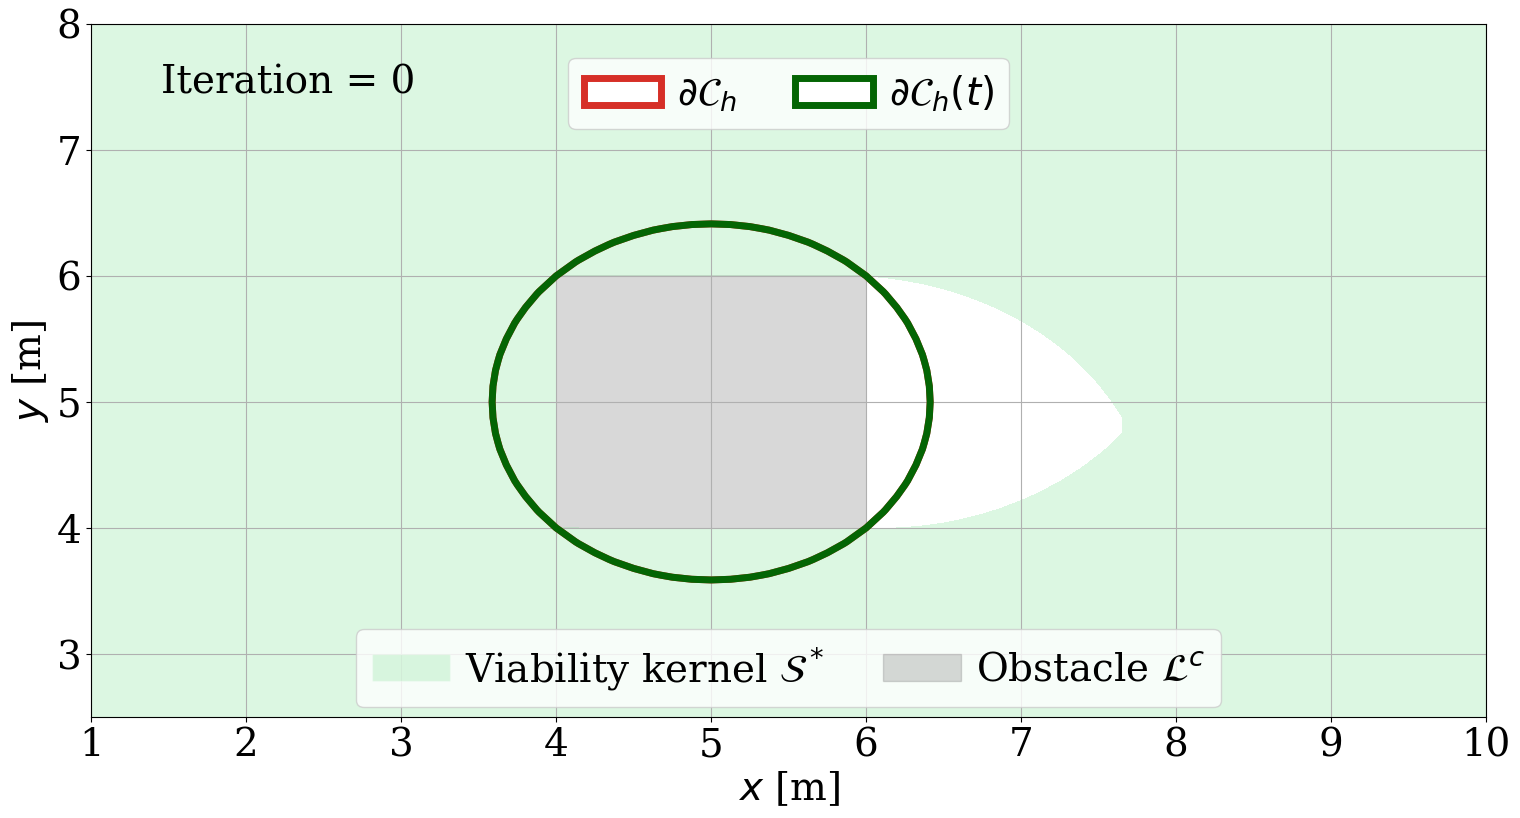

In [46]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()

    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[i][..., offset], levels=[0], 
                      colors=np.array([colors[-1]]))
    if toggle_hjr_visualization:
        global cont2
        for c in cont2.collections:
            c.remove()
        cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[i][..., offset], levels=[0],
                           colors=np.array([chosen_colors[0]]))


filename = "dubins.mp4"
fig, ax = plt.subplots(1, 1, figsize=(18,9 ))

proxy = [] 
obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
                           levels=[-10, 0], colors='grey', alpha=0.3)

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], levels=[0, 50], 
                 colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[3]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[3], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.05, 0.9, "", transform=ax.transAxes)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[-1]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[-1], fc='white', lw=5)
          for pc in cont.collections]
if toggle_hjr_visualization:
    cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[0][..., offset], levels=[0], 
                       colors=np.array([chosen_colors[0]]))
    proxy += [plt.Rectangle((0,0),1,1,ec = chosen_colors[0], fc='white', lw=5)
              for pc in cont2.collections]

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_xlim([1, 10])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$ [m]")

proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3) for pc in cs.collections]
proxy2 += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
leg = ax.legend(proxy, legend_entries, 
          loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.legend(proxy2, ["Viability kernel $\mathcal{S}^*$", "Obstacle $\mathcal{L}^c$"],
          loc='center', bbox_to_anchor=(0.5, 0.07), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.add_artist(leg)


render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 5 // 16, interval=100)

if save_video: 
    animation.save(filename, writer='ffmpeg')